### Assignment 1 (due Wednesday, Sep 10th, 11:59 pm)

Submit your completed .ipynb file to the corresponding Brightspace assignment.

#### Overview:

In this assignment, you’ll become familiar with PyTorch by following the [official tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html). You will also implement a classifier for the CIFAR-10 dataset and adapt it to use the d2l library’s API.


#### Tasks:
* **Follow the tutorial:** Start by reading and completing the tutorial to gain an understanding of PyTorch basics.
* **Implement a CIFAR-10 Classifier:** Build a classifier for the CIFAR-10 dataset. You are free to design the network structure and choose the hyperparameters.
* **Port to d2l API:** Adapt your classifier to the d2l library by creating two classes: ***d2l.Classifier*** and ***d2l.DataModule***. Use these to fit your model.

#### Hints:
* For the d2l API implementation, you can refer to examples from previous chapters (e.g., Example 5.6). Chapters 6 and 23.8 are also good references.
* You can check the source code in d2l, such as the FashionMNIST dataset implementation in `d2l/torch.py`.
* Your final model should achieve a **validation accuracy (val_acc) of at least 0.70**, similar to the example figure below.
<br><br>


<div align="center">
  <img src="attachment:a34e5eb8-fecb-4d52-ab9d-da1286186b84.png" alt="image.png">
</div>

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
!pip install -U pip setuptools wheel
!pip install "numpy>=1.26,<2.3" "matplotlib>=3.7" "torch>=2.1" "torchvision" jupyter==1.0.0
!pip install --no-deps d2l==1.0.3

In [13]:
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

## Your d2l.Classifier and d2l.DataModule

In [17]:
##### YOUR CLASSIFIER AND DATAMODULE HERE #####
class CIFAR10(d2l.DataModule):
  def __init__(self, batch_size=128, resize=(32,32)):
    super().__init__()
    self.save_hyperparameters()
    mean = (0.4914, 0.4822, 0.4465)
    std  = (0.2470, 0.2435, 0.2616)

    self.train_trans = torchvision.transforms.Compose([
        torchvision.transforms.Resize(resize),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean, std)
    ])
    self.test_trans = torchvision.transforms.Compose([
        torchvision.transforms.Resize(resize),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean, std)
    ])
    self.train = torchvision.datasets.CIFAR10(
        root=self.root, train=True, transform=self.train_trans, download=True
    )
    self.val = torchvision.datasets.CIFAR10(
        root=self.root, train=False, transform=self.test_trans, download=True
    )
  def get_dataloader(self, train):
    ds = self.train if train else self.val
    return torch.utils.data.DataLoader(ds, self.batch_size, shuffle=train, num_workers=self.num_workers)

class Classifier(nn.Module, d2l.HyperParameters):
  def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2),
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2),
        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.Linear(256, 10)
    )
    self.board = d2l.ProgressBoard()
  def forward(self, X):
    return self.net(X)

  def loss(self, y_hat, y):
    return nn.functional.cross_entropy(y_hat, y)

  @torch.no_grad()
  def accuracy(self, y_hat, y):
    return (y_hat.argmax(dim=1) == y).float().mean()

  def plot(self, key, value, train):
    self.board.xlabel = 'epoch'
    if train:
      x = self.trainer.train_batch_idx / \
          len(self.trainer.train_dataloader)
      n = self.trainer.num_train_batches / \
          self.plot_train_per_epoch
    else:
      x = self.trainer.epoch + 1
      n = self.trainer.num_val_batches / \
          self.plot_valid_per_epoch
    self.board.draw(x, value.to(d2l.cpu()).detach().numpy(),
                    ('train_' if train else 'val_') + key, every_n=int(n))
  def training_step(self, batch):
    X, y = batch
    y_hat = self(X)
    l = self.loss(y_hat, y)
    self.plot('loss', l, train=True)
    acc = self.accuracy(y_hat, y)
    self.plot('acc', self.accuracy(y_hat, y), train=True)
    return l

  @torch.no_grad()
  def validation_step(self, batch):
    X, y = batch
    y_hat = self(X)
    l = self.loss(y_hat, y)
    self.plot('loss', l, train=False)
    acc = self.accuracy(y_hat, y)
    self.plot('acc', self.accuracy(y_hat, y), train=False)
    return l

  def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), lr=0.1)




## Training Routine
Your training routine should train the classifier and output a loss plot similar to the one above, where the validation accuracy is at least 0.7 at the end of the run.   Please use functions from the d2l library to train (the Trainer class, .fit()).

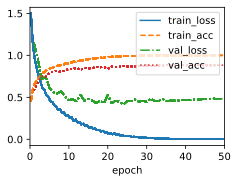

In [18]:
##### YOUR TRAINING ROUTINE HERE #####
data = CIFAR10()
model = Classifier()
trainer = d2l.Trainer(max_epochs=50)
trainer.fit(model, data)
